In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook

dt = 1.5, time_steps = 6666


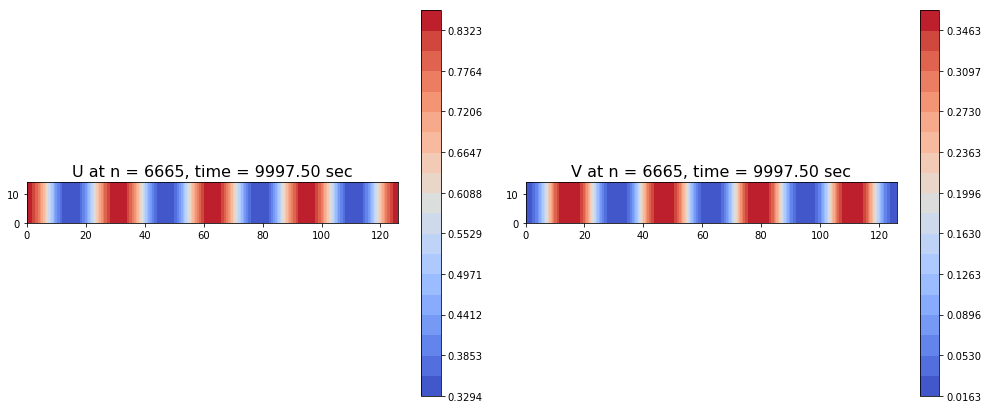

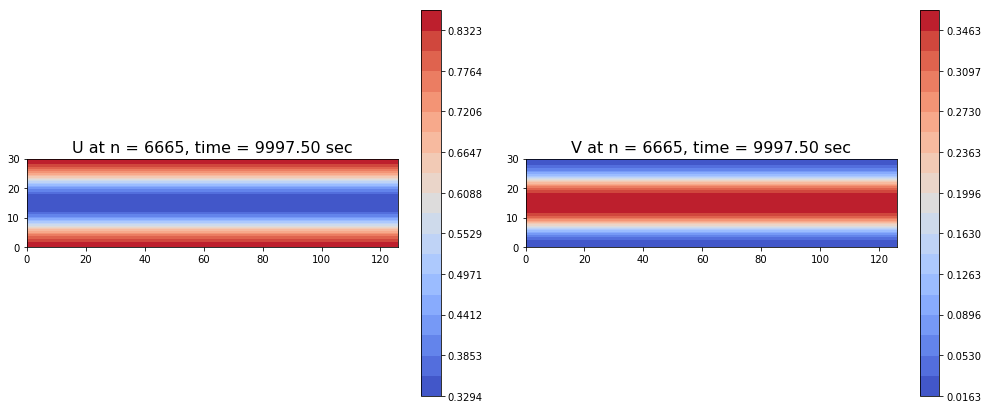

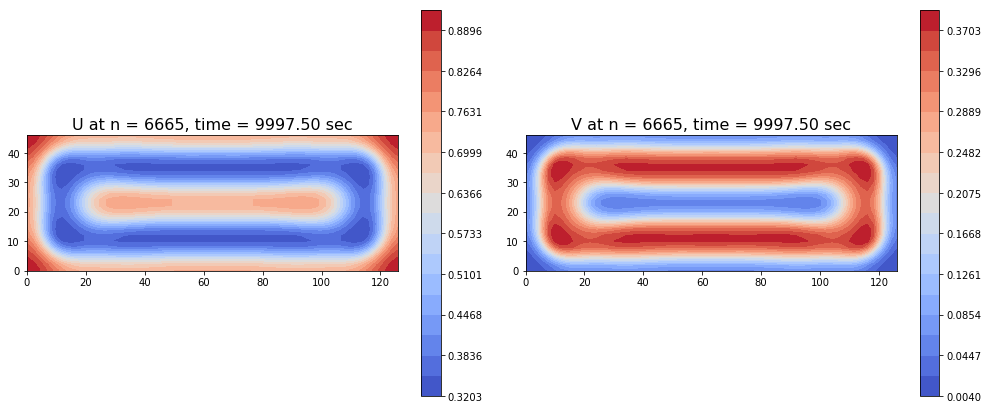

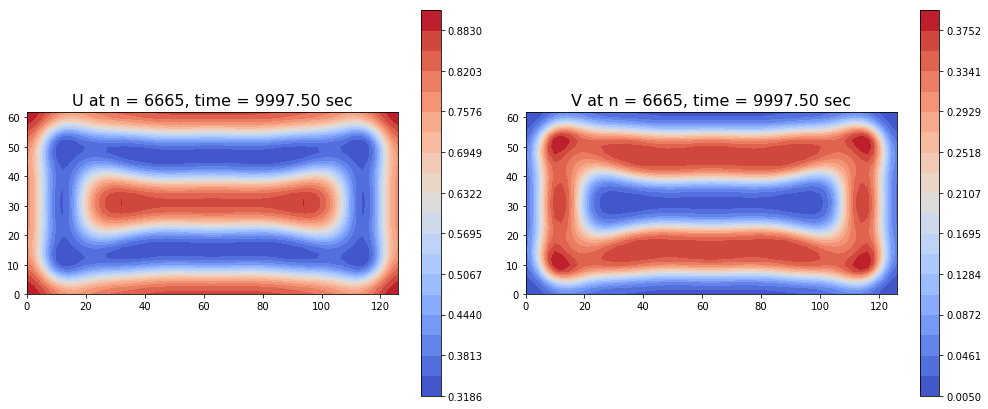

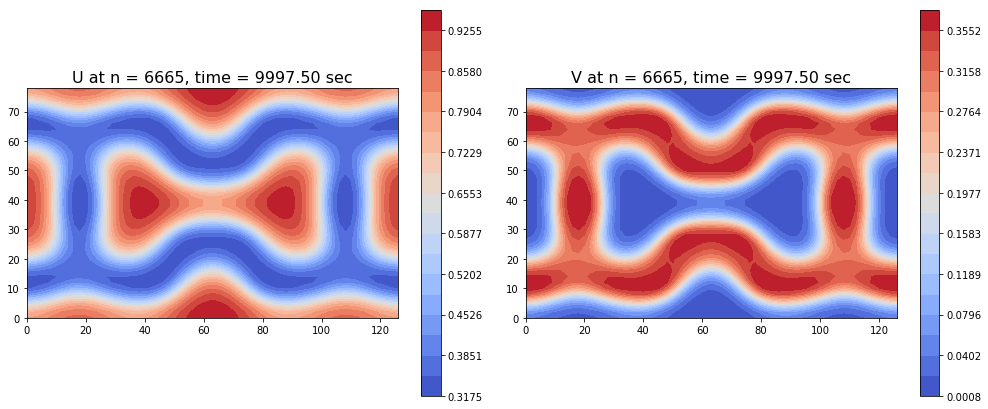

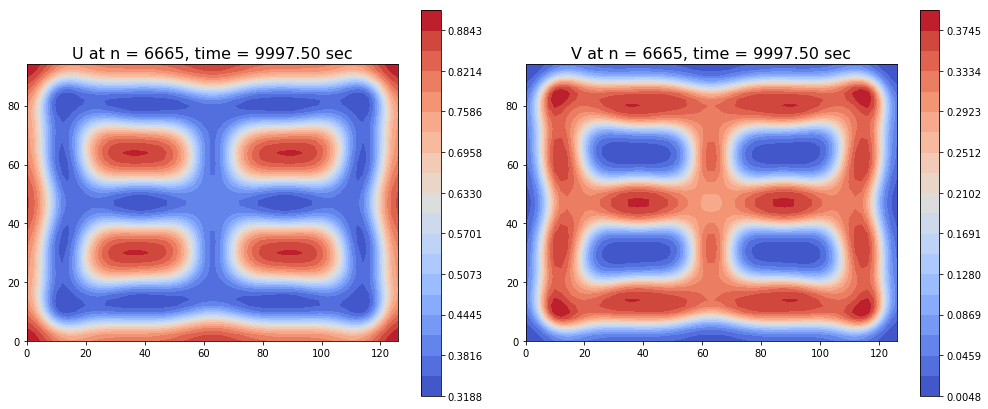

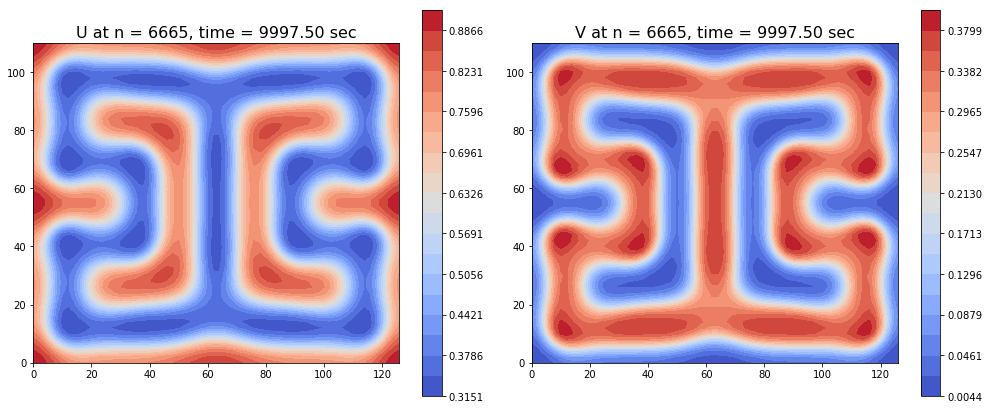

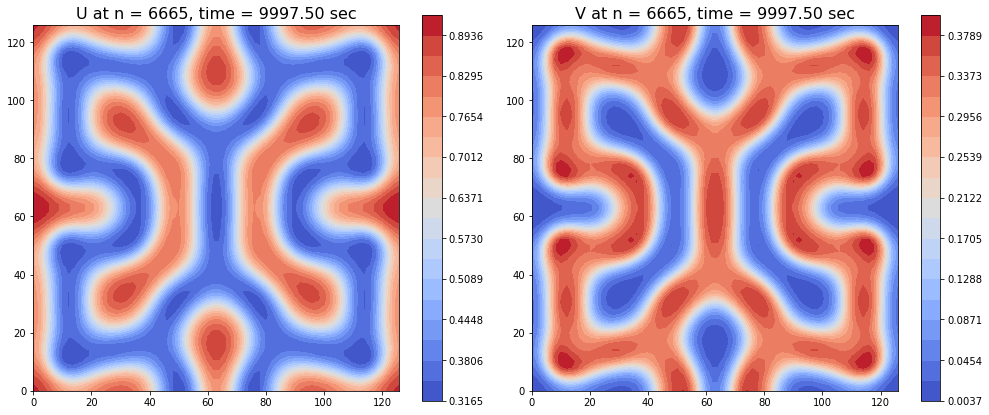

In [2]:
# Grid setup
Ny_list = [8, 16, 24, 32, 40, 48, 56, 64]
Nx = 64
h = 2

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

for Ny in Ny_list:
    # Construct transform matrices
    D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
    D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
    Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
    Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
    Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
    Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

    # Factorize matrices
    solve_Tu_x = linalg.factorized(Tu_x.tocsc())
    solve_Tu_y = linalg.factorized(Tu_y.tocsc())
    solve_Tv_x = linalg.factorized(Tv_x.tocsc())
    solve_Tv_y = linalg.factorized(Tv_y.tocsc())

    # Initial condition
    U_init = np.zeros((Ny, Nx))
    V_init = np.zeros((Ny, Nx))
    U_init[:, :] = 1

    j_0 = int(3/8*Ny)
    j_1 = int(5/8*Ny)
    k_0 = int(3/8*Nx)
    k_1 = int(5/8*Nx)
    V_init[j_0:j_1, k_0:k_1] = 1

    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    # Generate pattern
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
            + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) \
            + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)

    plot_pattern(U, V, time_steps-1, time_steps-1, h, dt, filled=True)
